In [30]:
import graph_tool.all as gt
from math import sqrt

In [31]:
from random import *

In [32]:
csvGraphsPath="../graphs/csv/"
csvGraphFileName="facebook_combined.csv"
csvGraphFilePath=csvGraphsPath+csvGraphFileName
fbGraph=gt.load_graph_from_csv(csvGraphFilePath)

In [33]:
import igraph as ig

In [34]:
F=ig.Graph.Read("../graphs/ncol/facebook_combined.txt",format="ncol").as_undirected()

In [35]:
print(F.vs[2])

igraph.Vertex(<igraph.Graph object at 0x7f6dcb1738b0>, 2, {'name': 'V0'})


In [36]:
partition=F.community_multilevel()

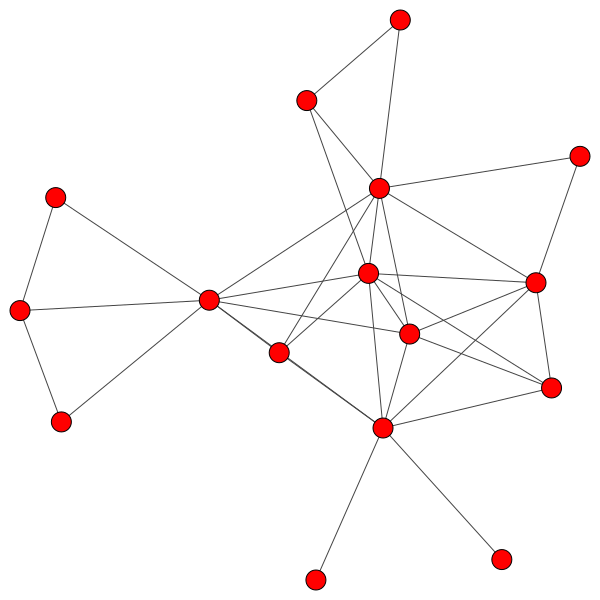

In [37]:
clusters=partition.cluster_graph()
ig.plot(clusters)

In [38]:
len(clusters.vs)
print(clusters.is_weighted())

False


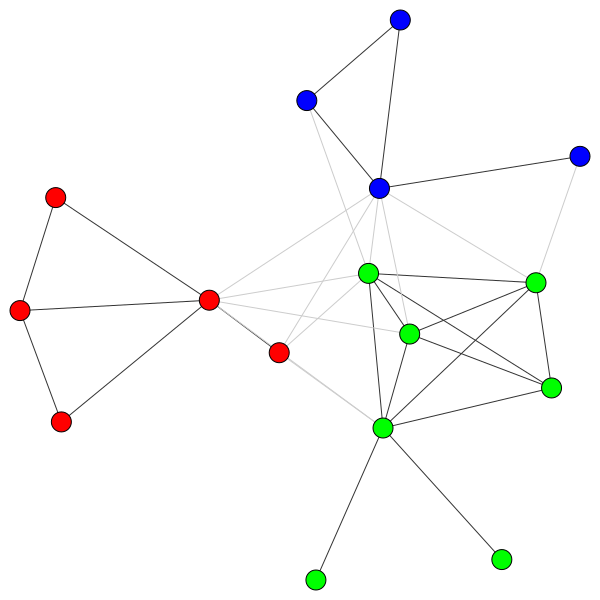

In [39]:
subpartition=clusters.community_leading_eigenvector()
ig.plot(subpartition)

In [40]:
len(subpartition)

3

In [41]:
for c in partition:
    color=[random(),random(),random(),1.]
    for v in c:
        partition.graph.vs[v]["color"]=color
        for e in partition.graph.incident(v):
            ed=partition.graph.es[e]
            if ed.source in c and ed.target in c:
                ed["color"]=[0.,0.,0.,1.]
            else:
                ed["color"]=[0.5,0.5,0.5,1.]

In [42]:
#print(partition)

In [58]:
def chooseVertex(graph):
    assert len(graph.vs)>0, "Can't choose a vertex in an empty graph." 
    node=None
    minBetweenness = -1
    for idx, betweenness in enumerate(clusterGraph.betweenness()):
        if betweenness < minBetweenness or minBetweenness == -1 :
            node= idx
    assert node is not None
    return node

In [49]:
def maxMinPCCNodeSelection(dictPCC):
    assert dictPCC!={}
    chosenId=None
    nbNodes=len(list(dictPCC.values())[0])
    maxDist=-1
    maxDistNode=None
    for nodeId in range(nbNodes):
        if nodeId not in dictPCC.keys():
            minDist=-1
            minDistNode=nodeId
            for chosenNode in dictPCC.keys():
                if minDist==-1 or dictPCC[chosenNode][nodeId]<minDist:
                    minDist=dictPCC[chosenNode][nodeId]
            if minDist>maxDist:
                maxDist=minDist
                maxDistNode=minDistNode
    chosenId=maxDistNode
    return chosenId

In [50]:
def maxShortestPathNodesSelection(graph,nbNodes,boundaryNodes=[]):
    if boundaryNodes==[]:
        chosenIds=[chooseVertex(graph)]
    else:
        chosenIds=boundaryNodes.copy()
    #BFS initial des noeuds dans chosenIds
    matPCC=graph.shortest_paths_dijkstra(chosenIds)
    dictPCC={chosenId:matPCC[idxPCC] for idxPCC,chosenId in enumerate(chosenIds)}
    print("d",dictPCC)
    #nbNodes fois
    print("l",len(chosenIds),nbNodes)
    while len(chosenIds)<nbNodes:
        print(".")
        chosenNodeId=maxMinPCCNodeSelection(dictPCC)
        #BFS du nouveau noeud
        dictPCC[chosenNodeId]=graph.shortest_paths_dijkstra(chosenNodeId)[0] #On prend la ligne de la matrice qui correspond au noeud
        chosenIds.append(chosenNodeId)
    return chosenIds[len(boundaryNodes):]

In [46]:
def assignWorkers(partition,nWorkers):
    assert nWorkers>=0, "{} workers to assign: Number of workers to assign must be positive or zero".format(nWorkers)
    assert len(partition.graph.vs)>=nWorkers, "{} workers to assign on {} nodes: Can't assign more workers than there are vertices".format(nWorkers,len(partition.graph.vs))

    clusterGraph=partition.cluster_graph()
    for idx, cluster in enumerate(clusterGraph.vs):
        cluster["name"]="C{}".format(idx)
    #print(clusterGraph)
    workerIds=[]
    chosenClusters=[]
    if len(partition)<nWorkers:
        pass #Etape 1'
    #PC:il y a au moins autant de clusters que de workers
    if len(partition)==nWorkers:
        #1cluster/1worker
        for cluster in clusterGraph.vs[2:]:
            cluster["nb_workers"]=1
    else:
        workerIds=maxShortestPathNodesSelection(clusterGraph,nWorkers)
    #Etape2
    #for chaque cluster de workers
    #prendre son sous-graphe+ les noeuds frontaliers d'autres clusters, BFS des frontières et Etape1 nb_workers fois
    #print([v["nb_workers"] for v in clusterGraph.vs])
    assert len(workerIds)==nWorkers
    return workerIds

In [70]:
workerIds=assignWorkers(partition,6)

d {15: [2, 2, 2, 1, 2, 3, 2, 3, 2, 1, 3, 3, 3, 3, 3, 0]}
l 1 6
.
.
.
.
.


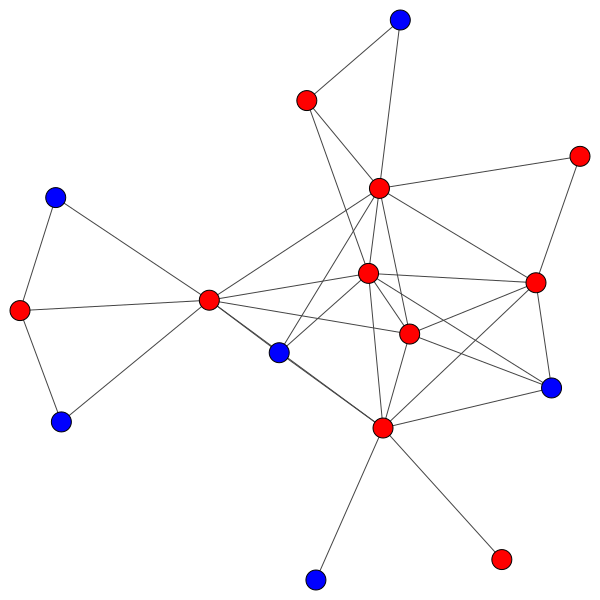

In [71]:
clusterGraph=partition.cluster_graph()
for cluster in clusterGraph.vs:
    if cluster.index in workerIds:
        cluster["color"]="blue"
ig.plot(clusterGraph)

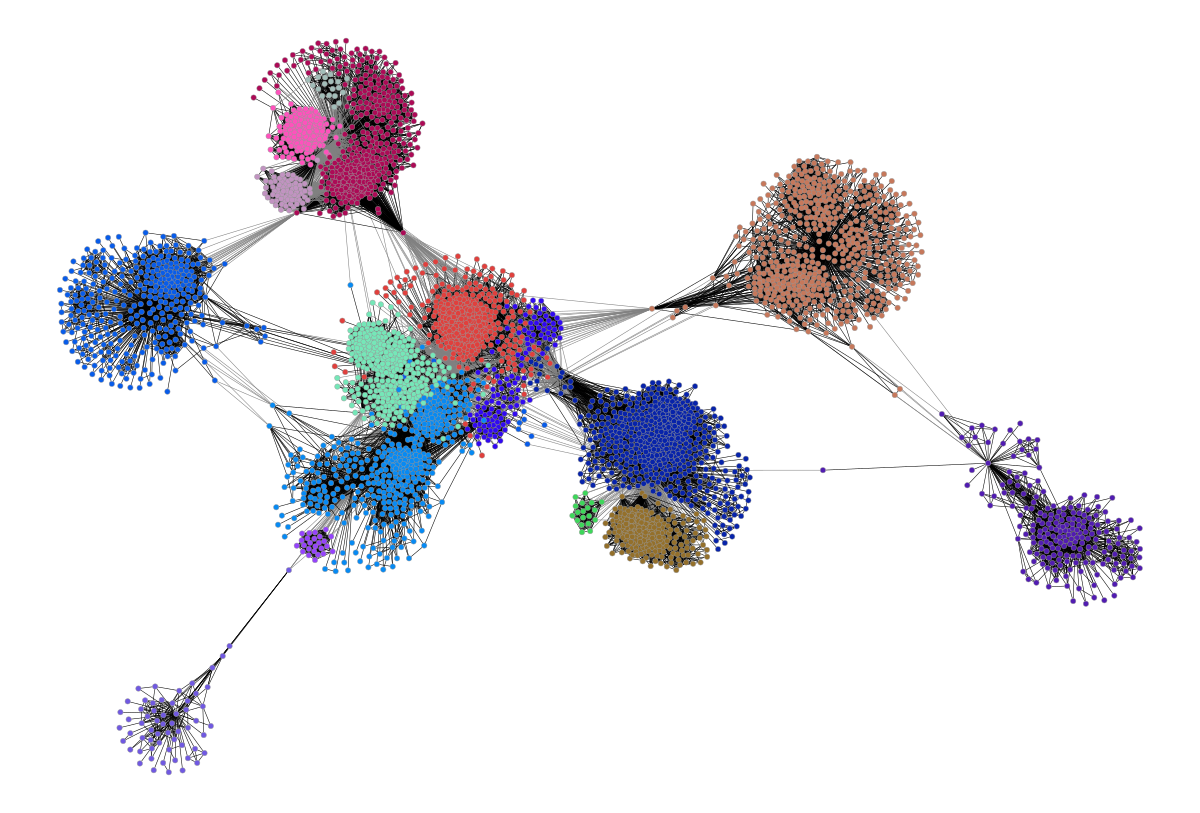

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f6dcb0f9ee0, at 0x7f6e01595be0>

In [61]:
G=partition.graph.to_graph_tool(vertex_attributes={"color":"vector<float>"},edge_attributes={"color":"vector<float>"})
gt.graph_draw(G, vertex_fill_color=G.vertex_properties["color"],edge_color=G.edge_properties["color"])